# Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100

# Use GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformation for the Data

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-100 dataset

In [4]:
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Data Loaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Model Architecture

## Squeeze-and-Excitation block

In [6]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

## Basic Block

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = nn.functional.leaky_relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.leaky_relu(out)
        return out

## Bottle Neck Block

In [8]:
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.se = SELayer(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = nn.functional.leaky_relu(self.bn1(self.conv1(x)))
        out = nn.functional.leaky_relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = nn.functional.leaky_relu(out)
        return out

## Custom CNN Model

In [9]:
class ModifiNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, dropout_prob=0.5):
        super(ModifiNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.functional.leaky_relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

# CNN Model Initialization

In [10]:
# model = ModifiNet(BasicBlock, [2, 2, 2, 2]).to(device) # 18 layers
# model = ModifiNet(BasicBlock, [3, 4, 6, 3]).to(device) # 34 layers
model = ModifiNet(BottleNeck, [3, 4, 6, 3]).to(device) # 50 layers
# model = ModifiNet(BottleNeck, [3, 4, 23, 3]).to(device) # 101 layers
# model = ModifiNet(BottleNeck, [3, 8, 36, 3]).to(device) # 152 layers

In [11]:
model

ModifiNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=256, out_features=16, bias=False)
          (1): LeakyReLU(negative_slope=0.01, inplace=True)
          (

# Define loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Learning Rate Scheduler

In [13]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Lists to store training statistics

In [14]:
train_loss_history = []
train_accuracy_history = []

# Train the model

In [15]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Adjust learning rate
    scheduler.step()
    
    # Calculate and store training statistics
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_loss_history.append(avg_loss)
    train_accuracy_history.append(accuracy)

    # Print training statistics
    print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item()}")

Epoch 0/50 - Loss: 4.035720348358154
Epoch 1/50 - Loss: 3.900012254714966
Epoch 2/50 - Loss: 3.2058074474334717
Epoch 3/50 - Loss: 2.7035040855407715
Epoch 4/50 - Loss: 2.7608723640441895
Epoch 5/50 - Loss: 2.527571201324463
Epoch 6/50 - Loss: 2.041196823120117
Epoch 7/50 - Loss: 2.2960591316223145
Epoch 8/50 - Loss: 2.190824031829834
Epoch 9/50 - Loss: 2.1982884407043457
Epoch 10/50 - Loss: 1.9597879648208618
Epoch 11/50 - Loss: 1.8974449634552002
Epoch 12/50 - Loss: 1.797419786453247
Epoch 13/50 - Loss: 1.7842706441879272
Epoch 14/50 - Loss: 1.6890556812286377
Epoch 15/50 - Loss: 1.3917137384414673
Epoch 16/50 - Loss: 1.283665657043457
Epoch 17/50 - Loss: 1.688993215560913
Epoch 18/50 - Loss: 1.753531813621521
Epoch 19/50 - Loss: 1.6296863555908203
Epoch 20/50 - Loss: 1.0018284320831299
Epoch 21/50 - Loss: 0.7418841123580933
Epoch 22/50 - Loss: 0.8014019131660461
Epoch 23/50 - Loss: 0.8629846572875977
Epoch 24/50 - Loss: 0.9198586344718933
Epoch 25/50 - Loss: 0.6887520551681519
Epoch

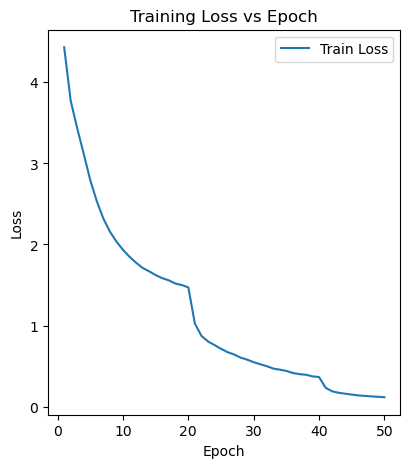

In [16]:
# Plot training statistics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()

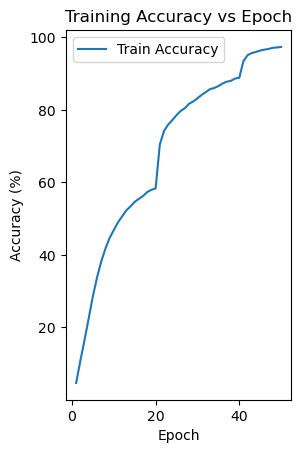

In [17]:
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy vs Epoch')
plt.legend()

# Test the model

In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Print Test Accuracy

In [20]:
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 75.29%


# Predict some images in the test set and display them

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


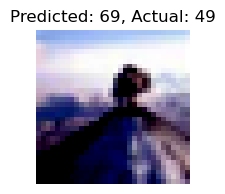

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


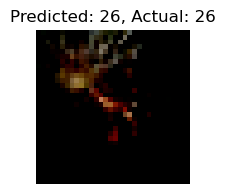

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


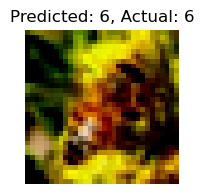

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


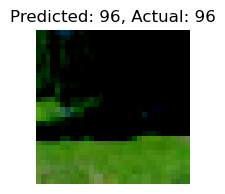

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


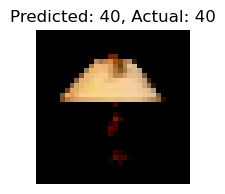

In [22]:
model.eval()
num_images_to_display = 5

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        if i == num_images_to_display:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Display the original image
        plt.figure(figsize=(2, 2))
        plt.imshow(np.transpose(inputs[0].cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Predicted: {predicted[0].item()}, Actual: {targets[0].item()}')
        plt.show()

In [23]:
torch.save(model.state_dict(), './model/cifar100-ModifiNet-model.pth')